In [2]:
!pip install transformers

In [3]:
from createModel import *

In [4]:
mod, tok = buildModelGPT()

In [7]:
def gen_fake_text(start_text, start_secret, secret_text):
  secret_text_encoded = tok.encode(secret_text)
  all_encoded = tok.encode(start_secret)
  all_encoded.extend(secret_text_encoded)

  ranks = []

  for i in range(len(tok.encode(start_secret)), len(all_encoded)):
    ranks.append(getSecretTokens(mod, tok, all_encoded[:i], all_encoded[i]).item())

  # print(ranks)
  
  output_text = start_text
  output_index = tok.encode(start_text)

  for i in range(len(ranks)):
    output_index = evaluateWithInputId(mod, output_index, ranks[i])

  output_text = tok.decode(output_index)
  return output_text

In [5]:
start_text = """
Welcome to the Shakespeare festival in London, UK. Today
"""

start_secret = "Secret"
secret_text = "A secret message for Joe"

In [13]:
# Idea 1: use randomly generated ranks instead of calculated ones
# Idea 2: give only steganographic part (without starting text) to classifier
# Idea 3: fiddle around with (precision/recall trade-off)
# Idea 4: Perplexity-based steganography
# Idea 5: run GLTR on cluster

In [8]:
print(gen_fake_text(start_text, start_secret, secret_text))


Welcome to the Shakespeare festival in London, UK. Today
Too black today and indeed


# Convert to tensor


In [2]:
def convert_to_tensor(text, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        return text

In [3]:
convert_to_tensor('hello my name is', vocab=train_dataset.get_vocab(), ngrams=NGRAMS)

NameError: name 'train_dataset' is not defined

In [1]:
from nltk.corpus import brown
import nltk
nltk.download('brown')

news_text = brown.sents(categories=['news'])[:50]
fake_news = []
true_news = []

secret_text_length = 5

[nltk_data] Downloading package brown to /home/mark/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [101]:
for sentence in news_text:
  if len(sentence) < secret_text_length:
    continue

  sentence_true = ' '.join(sentence)

  true_news.append(sentence_true)

  sentence_fake = ' '.join(sentence[:-secret_text_length])
  sentence_fake = gen_fake_text(sentence_fake, start_secret, secret_text)

  fake_news.append(sentence_fake)

"The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that paint Randolph Park for Trayvon"

# Creating and training a model


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

destination_folder = './lstm/'

train_test_ratio = 0.90
train_valid_ratio = 0.80

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

In [5]:
#true_dict = dict({(i, 0) for i in true_news})
#fake_dict = dict({(i, 1) for i in fake_news})
#all_dict = {**true_dict, **fake_dict}
#print(all_dict)

#true_dict = {'text': true_news, 'label': 0}
#fake_dict = {'text': fake_news, 'label': 1}
#all_dict = {**true_dict, **fake_dict}

all_dict = {'text': true_news + fake_news, 'label': [0]*len(true_news)+[1]*len(fake_news)}

df = pd.DataFrame(data=all_dict, columns=['label', 'text'])
df

,label,text


In [185]:
# Read raw data
df_raw = df

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [186]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [200]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=destination_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=3, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [202]:

class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [203]:

# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [208]:

# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:      
            #print(labels)
            #print(text)     
            #labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu())

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len.cpu())

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.device('cpu')
train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [2/50], Train Loss: 0.6540, Valid Loss: 0.5407
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [1/10], Step [4/50], Train Loss: 0.5048, Valid Loss: 0.4276
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [2/10], Step [6/50], Train Loss: 0.4800, Valid Loss: 0.3491
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [2/10], Step [8/50], Train Loss: 0.2927, Valid Loss: 0.2867
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [2/10], Step [10/50], Train Loss: 0.3191, Valid Loss: 0.2363
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [3/10], Step [12/50], Train Loss: 0.2451, Valid Loss: 0.1974
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [3/10], Step [14/50], Train Loss: 0.1590, Valid Loss: 0.1657
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [4/10], Ste

Model loaded from <== ./lstm//metrics.pt


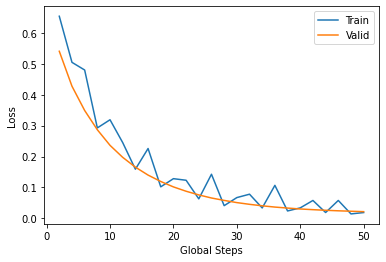

In [209]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== ./lstm//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        10
           0     1.0000    1.0000    1.0000        10

    accuracy                         1.0000        20
   macro avg     1.0000    1.0000    1.0000        20
weighted avg     1.0000    1.0000    1.0000        20



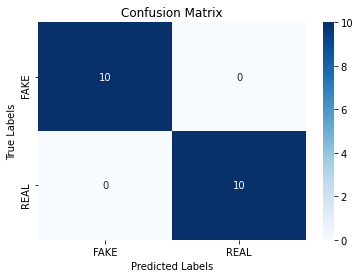

In [212]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu())

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)